In [35]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import pyarrow as pa
import pyarrow.dataset as ds
import pywt

# file path
file_path = "C:\\Users\\Meher\\Downloads\\06-12-2025-20250926T184310Z-1-001\\06-12-2025"
# create the test image variable for testing of an individual Biofilm Tiff file
test_image = tiff.imread("C:\\Users\\Meher\\Downloads\\06-12-2025-20250926T184310Z-1-001\\06-12-2025\\Untreated_20x_XY01_Z100_CH2.tif")

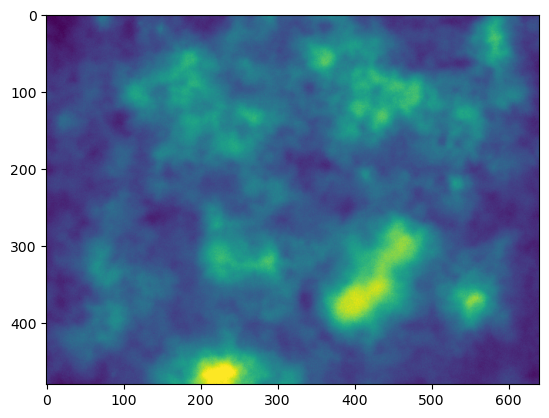

In [45]:
gray_image = color.rgb2gray(test_image)
plt.imshow(gray_image)

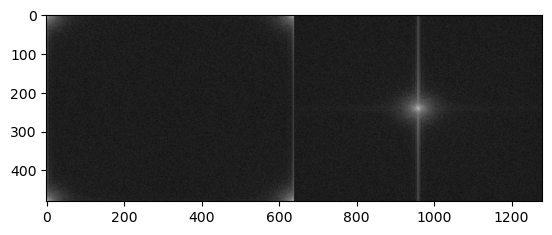

In [61]:
f_transform = np.fft.fft2(gray_image)
f_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = 20* np.log(np.abs(f_shifted) + 1)
magnitude_spectrum2 = 20* np.log(np.abs(f_transform) + 1)
plt.imshow(np.hstack((magnitude_spectrum2,magnitude_spectrum)), cmap='gray')


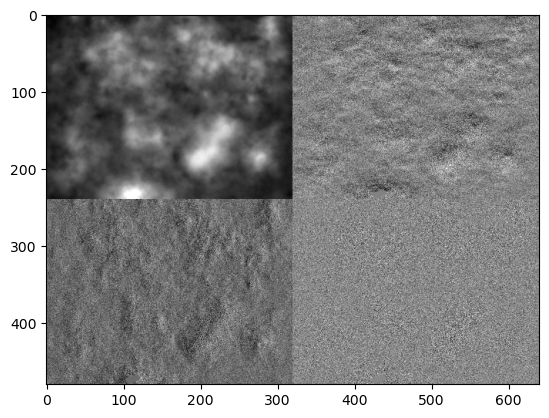

In [57]:
coeffs = pywt.dwt2(gray_image, 'haar')
LL, (LH, HL, HH) = coeffs

def normalize(img):
    img = img - np.min(img)
    img = img / np.max(img)
    return img

LLn = normalize(LL)
LHn = normalize(LH)
HLn = normalize(HL)
HHn = normalize(HH)

top = np.hstack((LLn, LHn))
bottom = np.hstack((HLn, HHn))
stacked = np.vstack((top, bottom))

plt.imshow(stacked, cmap='gray')